In [3]:
label = [0,1,2,3,4,5]
available_actions = [
            "Play/Pause - space",
            "Next - ctrl right",
            "Back - ctrl left",
            "Vol up - ctrl up",
            "Vol down - ctrl down",
            "Repeat - ctrl R"
        ]
gesture_shortcuts = {label: available_actions[0] for label in label}
gesture_shortcuts

{0: 'Play/Pause - space',
 1: 'Play/Pause - space',
 2: 'Play/Pause - space',
 3: 'Play/Pause - space',
 4: 'Play/Pause - space',
 5: 'Play/Pause - space'}

In [3]:
import cv2
import mediapipe as mp
import pyautogui
import csv
import time
import numpy as np
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QHBoxLayout, QLabel, QComboBox, QPushButton, QWidget
from PyQt5.QtGui import QImage, QPixmap
from PyQt5.QtCore import QTimer
from CvFpsCalc import CvFpsCalc
from functions import *
from tensorflow.keras.models import load_model
import os


In [4]:

class WebcamViewer(QMainWindow):

    def __init__(self):
        super().__init__()

        self.setWindowTitle("Webcam Viewer with Hand Detection")
        self.setGeometry(100, 100, 1280, 720)  # Set to 16:9 ratio with 720p resolution
        self.setFixedSize(1280, 720)  # Make the window non-resizable

        # Variables
        self.current_camera_index = 0
        # self.current_model_path = 'models/keypoint_classifier_demo_2.keras'
        self.capture = None
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5, max_num_hands=1)
        self.mp_draw = mp.solutions.drawing_utils
        self.hand_detection_enabled = False

        self.cvFpsCalc = CvFpsCalc(buffer_len=10)
        # Model-related variables
        self.models_folder = "models"  # Path to the models folder
        self.model = load_model("models/keypoint_classifier.keras")
        self.keypoint_classifier_labels = self.get_labels()
        self.last_keybind_time = time.time()

        # Shortcut mappings
        self.available_actions = [
            "Play/Pause - space",
            "Next - ctrl right",
            "Back - ctrl left",
            "Vol up - ctrl up",
            "Vol down - ctrl down",
            "Repeat - ctrl R"
        ]
        self.gesture_shortcuts = {label: self.available_actions[0] for label in self.keypoint_classifier_labels}

        # Setup UI
        self.init_ui()

        # Start Timer
        self.timer = QTimer()
        self.timer.timeout.connect(self.update_frame)
        self.timer.start(1)
        self.fps_list = []

    def init_ui(self) -> None:
        # Main layout
        main_layout = QHBoxLayout()

        # Left layout (Camera and Controls)
        left_layout = QVBoxLayout()

        # Dropdown for camera selection
        self.camera_selector = QComboBox()
        cameras = self.list_cameras()
        self.camera_selector.addItems([f"Camera {i}" for i in cameras])
        self.camera_selector.currentIndexChanged.connect(self.switch_camera)
        left_layout.addWidget(self.camera_selector)

        # Dropdown for model selection
        self.model_selector = QComboBox()
        models = self.list_models()
        self.model_selector.addItems(models)
        self.model_selector.currentIndexChanged.connect(self.switch_model)
        left_layout.addWidget(self.model_selector)

        # Toggle button for hand detection
        self.toggle_button = QPushButton("Enable Hand Detection")
        self.toggle_button.clicked.connect(self.toggle_hand_detection)
        left_layout.addWidget(self.toggle_button)

        # Video Display
        self.video_label = QLabel()
        self.video_label.setFixedSize(640, 360)  # Set QLabel size to 16:9 ratio
        left_layout.addWidget(self.video_label)

        # Right layout (Gesture-Shortcut Mapping)
        right_layout = QVBoxLayout()

        # Define default shortcuts (corresponding to the image)
        default_shortcuts = {
            "0": "Play/Pause - space",
            "1": "Next - ctrl right",
            "2": "Back - ctrl left",
            "3": "Vol up - ctrl up",
            "4": "Vol down - ctrl down",
            "5": "Repeat - ctrl R",
        }

        # Add gesture labels and dropdowns
        self.dropdown_boxes = {}
        for label in self.keypoint_classifier_labels:
            row_layout = QHBoxLayout()

            # Gesture label
            gesture_label = QLabel(f"Gesture {label}")
            row_layout.addWidget(gesture_label)

            # Dropdown for shortcuts
            dropdown = QComboBox()
            dropdown.addItems(self.available_actions)
            if label in default_shortcuts:
                dropdown.setCurrentText(default_shortcuts[label])  # Set default value
            dropdown.currentTextChanged.connect(lambda action, l=label: self.update_shortcut_mapping(l, action))
            self.dropdown_boxes[label] = dropdown
            row_layout.addWidget(dropdown)

            right_layout.addLayout(row_layout)

        # Combine layouts
        main_layout.addLayout(left_layout)
        main_layout.addLayout(right_layout)

        # Set central widget
        container = QWidget()
        container.setLayout(main_layout)
        self.setCentralWidget(container)

        # Initialize camera
        if cameras:
            self.switch_camera(cameras[0])


    def list_cameras(self) -> list:
        available_cameras = []
        for index in range(5):  # Check first 5 camera indices
            cap = cv2.VideoCapture(index)
            if cap.isOpened():
                available_cameras.append(index)
                cap.release()
        return available_cameras

    def list_models(self) -> list:
        models_path = "models"
        if not os.path.exists(models_path):
            return []
        return [model for model in os.listdir(models_path) if model.endswith(".keras")]

    def switch_camera(self, index: int) -> None:
        self.current_camera_index = index
        if self.capture:
            self.capture.release()
        self.capture = cv2.VideoCapture(self.current_camera_index)

    def switch_model(self, index) -> None:
        model_name = self.model_selector.currentText()
        model_path = os.path.join(self.models_folder, model_name)

        # Load the selected model
        self.model = load_model(model_path)
        self.keypoint_classifier_labels = self.get_labels()
        print(f"Loaded model: {model_name}")

    def toggle_hand_detection(self) -> None:
        self.hand_detection_enabled = not self.hand_detection_enabled
        self.toggle_button.setText("Disable Hand Detection" if self.hand_detection_enabled else "Enable Hand Detection")

    def get_labels(self) -> list:
        with open('keypoint_classifier_label_2.csv', encoding='utf-8') as file:
            keypoint_classifier_labels = csv.reader(file)
            return [row[0] for row in keypoint_classifier_labels]

    def update_shortcut_mapping(self, label, action):
        if action == "Blank":
            self.gesture_shortcuts[label] = None  # No action
        else:
            self.gesture_shortcuts[label] = action

    def keybind(self, label, last_keybind_time):
        if last_keybind_time is None:
            last_keybind_time = time.time()  # Initialize if it's None

        current_time = time.time()  # Get current time
        if current_time - last_keybind_time < 5 or label == "Unknown":  # Delay 3 seconds
            return last_keybind_time

        action = self.gesture_shortcuts.get(label)

        if action == "Play/Pause - space":
            pyautogui.hotkey('space')

        elif action == "Next - ctrl right":
            pyautogui.hotkey('ctrl', 'right')

        elif action == "Back - ctrl left":
            pyautogui.hotkey('ctrl', 'left')

        elif action == "Vol up - ctrl up":
            pyautogui.hotkey('ctrl', 'up')

        elif action == "Vol down - ctrl down":
            pyautogui.hotkey('ctrl', 'down')

        elif action == "Repeat - ctrl R":
            pyautogui.hotkey('ctrl', 'r')

        print(action)
        return current_time

    def update_frame(self) -> None:
        if not self.capture or not self.capture.isOpened():
            return

        ret, frame = self.capture.read()
        if not ret:
            return

        fps = self.cvFpsCalc.get()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.flip(frame, 1)

        # Process frame
        if self.hand_detection_enabled:
            frame.flags.writeable = False
            results = self.hands.process(frame)
            frame.flags.writeable = True

            if results.multi_hand_landmarks:
                for hand_landmarks in (results.multi_hand_landmarks):
                    self.mp_draw.draw_landmarks(frame, hand_landmarks, self.mp_hands.HAND_CONNECTIONS)

                    Landmark_list = calc_landmark_list(frame, hand_landmarks)

                    pre_processed_landmark_list = pre_process_landmark(Landmark_list)

                    pred = self.model.predict(np.array([pre_processed_landmark_list]), verbose=0)
                    hand_sign_id = np.argmax(pred)
                    confidence_percentage = np.ceil(pred[0][hand_sign_id] * 100)

                    # Mark as 'Unknown' if confidence is below 80%
                    if confidence_percentage < 80:
                        hand_sign_text = "Unknown"
                    else:
                        hand_sign_text = self.keypoint_classifier_labels[hand_sign_id]

                    cv2.putText(frame, f'{hand_sign_text} - {confidence_percentage}', (10, 140), cv2.FONT_HERSHEY_PLAIN, 3, (255, 255, 255), 3)

                    self.last_keybind_time = self.keybind(hand_sign_text, self.last_keybind_time)  # Update the keybind time

        cv2.putText(frame, "FPS:" + str(fps), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 3, cv2.LINE_AA)
        self.fps_list.append(fps)
        height, width, channel = frame.shape
        step = channel * width
        q_img = QImage(frame.data, width, height, step, QImage.Format_RGB888)
        self.video_label.setPixmap(QPixmap.fromImage(q_img).scaled(self.video_label.width(), self.video_label.height()))

    def closeEvent(self, event):
        if self.capture:
            self.capture.release()
        self.hands.close()
        print(self.fps_list)
        super().closeEvent(event)


In [5]:
from PyQt5.QtWidgets import QApplication
import sys
from WebcamViewer2 import WebcamViewer

if __name__ == "__main__":
    app = QApplication([])
    viewer = WebcamViewer()
    viewer.show()
    app.exec_()
    print(viewer.fps_list)

[]


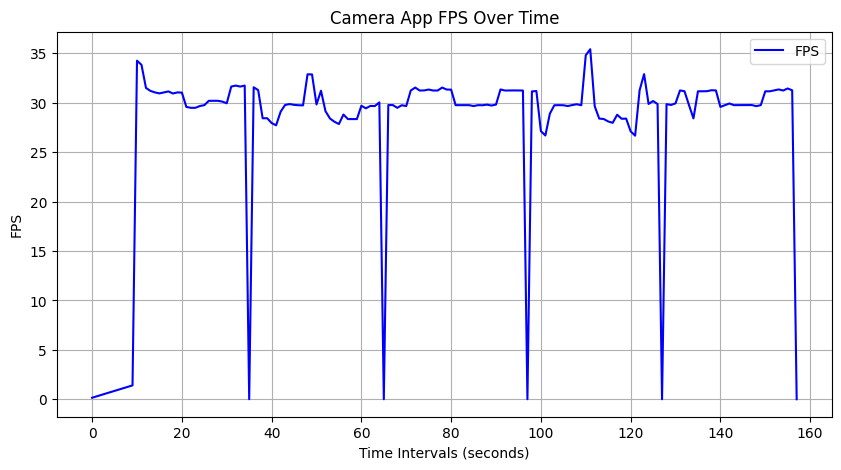

In [6]:
import matplotlib.pyplot as plt

# Example FPS data
fps_data = [0.15, 0.29, 0.43, 0.58, 0.72, 0.86, 0.99, 1.13, 1.27, 1.4, 34.26, 33.84, 31.5, 31.2, 31.05, 30.95, 31.05, 31.15, 30.94, 31.05, 31.03, 29.58, 29.49, 29.49, 29.67, 29.76, 30.2, 30.2, 30.2, 30.12, 29.95, 31.64, 31.74, 31.64, 31.74, 0, 31.57, 31.28, 28.43, 28.44, 27.95, 27.72, 29.09, 29.78, 29.87, 29.79, 29.75, 29.74, 32.88, 32.87, 29.83, 31.22, 29.15, 28.41, 28.08, 27.85, 28.81, 28.35, 28.35, 28.35, 29.7, 29.44, 29.68, 29.67, 30.04, 0, 29.77, 29.77, 29.49, 29.75, 29.67, 31.24, 31.54, 31.24, 31.25, 31.34, 31.24, 31.24, 31.54, 31.34, 31.33, 29.76, 29.76, 29.76, 29.76, 29.67, 29.76, 29.75, 29.81, 29.72, 29.82, 31.35, 31.24, 31.25, 31.25, 31.25, 31.24, 0, 31.15, 31.19, 27.13, 26.69, 28.9, 29.75, 29.76, 29.75, 29.67, 29.77, 29.85, 29.75, 34.81, 35.42, 29.64, 28.4, 28.36, 28.11, 27.97, 28.79, 28.38, 28.4, 27.11, 26.67, 31.27, 32.9, 29.88, 30.18, 29.87, 0, 29.86, 29.78, 29.94, 31.25, 31.17, 29.77, 28.42, 31.16, 31.16, 31.17, 31.27, 31.25, 29.58, 29.76, 29.93, 29.76, 29.76, 29.76, 29.75, 29.77, 29.66, 29.76, 31.16, 31.16, 31.25, 31.35, 31.24, 31.45, 31.26, 0]

plt.figure(figsize=(10, 5))
plt.plot(fps_data, label="FPS", color="blue")
plt.title("Camera App FPS Over Time")
plt.xlabel("Time Intervals (seconds)")
plt.ylabel("FPS")
plt.legend()
# plt.xticks([1, 2, 3, 4, 5])
plt.grid(True)
plt.show()


In [7]:
data = [0.15, 0.29, 0.43, 0.58, 0.72, 0.86, 0.99, 1.13, 1.27, 1.4, 34.26, 33.84, 31.5, 31.2, 31.05, 30.95, 31.05, 31.15, 30.94, 31.05, 31.03, 29.58, 29.49, 29.49, 29.67, 29.76, 30.2, 30.2, 30.2, 30.12, 29.95, 31.64, 31.74, 31.64, 31.74, 0, 31.57, 31.28, 28.43, 28.44, 27.95, 27.72, 29.09, 29.78, 29.87, 29.79, 29.75, 29.74, 32.88, 32.87, 29.83, 31.22, 29.15, 28.41, 28.08, 27.85, 28.81, 28.35, 28.35, 28.35, 29.7, 29.44, 29.68, 29.67, 30.04, 0, 29.77, 29.77, 29.49, 29.75, 29.67, 31.24, 31.54, 31.24, 31.25, 31.34, 31.24, 31.24, 31.54, 31.34, 31.33, 29.76, 29.76, 29.76, 29.76, 29.67, 29.76, 29.75, 29.81, 29.72, 29.82, 31.35, 31.24, 31.25, 31.25, 31.25, 31.24, 0, 31.15, 31.19, 27.13, 26.69, 28.9, 29.75, 29.76, 29.75, 29.67, 29.77, 29.85, 29.75, 34.81, 35.42, 29.64, 28.4, 28.36, 28.11, 27.97, 28.79, 28.38, 28.4, 27.11, 26.67, 31.27, 32.9, 29.88, 30.18, 29.87, 0, 29.86, 29.78, 29.94, 31.25, 31.17, 29.77, 28.42, 31.16, 31.16, 31.17, 31.27, 31.25, 29.58, 29.76, 29.93, 29.76, 29.76, 29.76, 29.75, 29.77, 29.66, 29.76, 31.16, 31.16, 31.25, 31.35, 31.24, 31.45, 31.26, 0]

# Find positions of 0
positions = [index for index, value in enumerate(data) if value == 0]
print(positions)


[35, 65, 97, 127, 157]


In [8]:
a = [34, 63, 94, 123, 152]

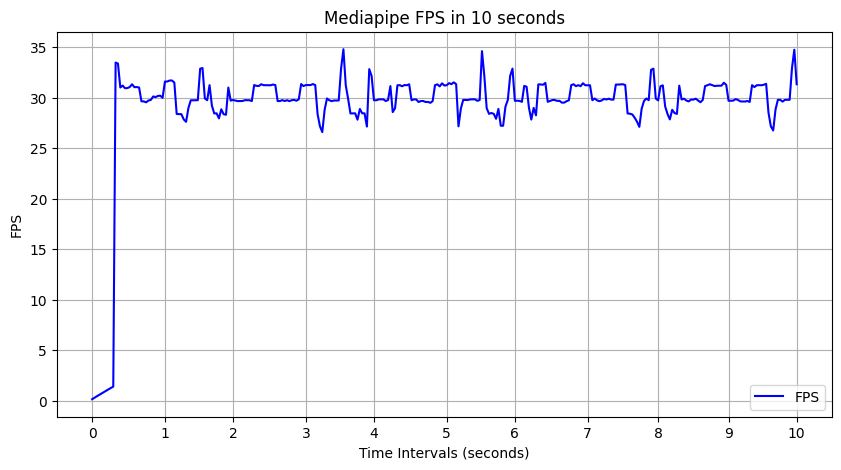

In [9]:
import matplotlib.pyplot as plt

# Example FPS data
fps_data = [0.14, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.12, 1.26, 1.39, 33.49, 33.39, 31.02, 31.21, 30.95, 30.96, 31.06, 31.34, 31.05, 31.06, 31.02, 29.65, 29.64, 29.55, 29.73, 29.79, 30.13, 30.07, 30.18, 30.21, 30.0, 31.61, 0, 31.61, 31.71, 31.71, 31.51, 28.4, 28.38, 28.38, 27.86, 
27.62, 28.98, 29.75, 29.75, 29.75, 29.76, 32.88, 32.95, 29.93, 29.76, 31.25, 29.22, 28.45, 28.46, 27.96, 28.86, 28.37, 28.32, 31.01, 29.72, 29.78, 0, 29.72, 29.67, 29.67, 29.68, 29.76, 29.76, 29.76, 29.67, 31.26, 31.18, 31.17, 31.34, 31.25, 31.25, 31.24, 31.24, 31.31, 31.26, 29.67, 29.68, 29.77, 29.68, 29.76, 29.67, 29.76, 29.79, 29.71, 29.85, 31.36, 31.16, 31.26, 0, 31.26, 31.26, 31.36, 31.26, 28.38, 27.18, 26.6, 28.81, 29.93, 29.75, 29.67, 29.73, 29.73, 29.73, 32.88, 34.81, 31.23, 29.9, 28.45, 28.45, 28.46, 27.83, 28.89, 28.46, 28.46, 27.15, 32.84, 32.16, 29.76, 0, 29.75, 29.84, 29.84, 29.85, 29.68, 29.77, 31.16, 28.58, 28.98, 31.24, 31.25, 31.14, 31.26, 31.24, 31.34, 29.76, 29.84, 29.84, 29.58, 29.68, 29.68, 29.58, 29.59, 29.5, 29.67, 31.25, 31.33, 31.13, 31.43, 31.21, 31.25, 0, 31.45, 31.35, 31.53, 31.35, 27.17, 28.92, 29.79, 29.78, 29.78, 29.84, 29.85, 29.85, 29.7, 29.77, 34.62, 32.16, 28.97, 28.41, 28.49, 28.41, 27.92, 28.9, 27.23, 27.23, 29.13, 29.78, 32.17, 32.89, 29.7, 0, 29.71, 29.69, 29.6, 31.18, 31.09, 29.01, 27.84, 29.0, 28.26, 31.33, 31.32, 31.29, 31.47, 29.6, 29.69, 29.78, 29.78, 29.69, 29.7, 29.52, 29.52, 29.66, 29.75, 31.25, 31.34, 31.15, 31.25, 31.15, 31.44, 31.24, 31.24, 0, 31.24, 29.76, 29.93, 29.75, 29.66, 29.74, 29.89, 29.83, 29.91, 29.82, 29.82, 31.31, 31.31, 31.33, 31.34, 31.26, 28.45, 28.42, 28.35, 28.03, 27.64, 27.12, 28.93, 29.69, 29.93, 29.76, 32.77, 32.88, 29.93, 29.74, 0, 31.14, 31.23, 29.14, 28.4, 27.86, 28.81, 28.49, 28.4, 31.2, 29.83, 29.91, 29.73, 29.64, 29.82, 29.82, 29.91, 29.73, 29.56, 29.78, 31.16, 31.24, 31.34, 31.26, 31.16, 31.19, 31.2, 31.2, 31.49, 31.28, 29.7, 0, 29.71, 29.72, 29.87, 29.79, 29.64, 29.63, 29.63, 29.68, 29.59, 31.25, 31.06, 31.24, 31.25, 31.24, 31.29, 31.38, 28.52, 27.17, 26.76, 28.85, 29.8, 29.8, 29.62, 29.8, 29.8, 29.8, 32.93, 34.76, 31.34,0]


filtered_data = [value for value in fps_data if value != 0]

plt.figure(figsize=(10, 5))
plt.plot(filtered_data, label="FPS", color="blue")
plt.title("Mediapipe FPS in 10 seconds")
plt.xlabel("Time Intervals (seconds)")
plt.ylabel("FPS")
plt.legend()

positions = [index for index, value in enumerate(fps_data) if value == 0]

a = 1
fps_list = [0, ]
for i in positions:
    i = i - a
    a += 1
    fps_list.append(i)
fps_list

xname = []
for i in range(len(fps_list)):
    xname.append(str(i))

plt.xticks(fps_list, xname)
plt.grid(True)
plt.show()


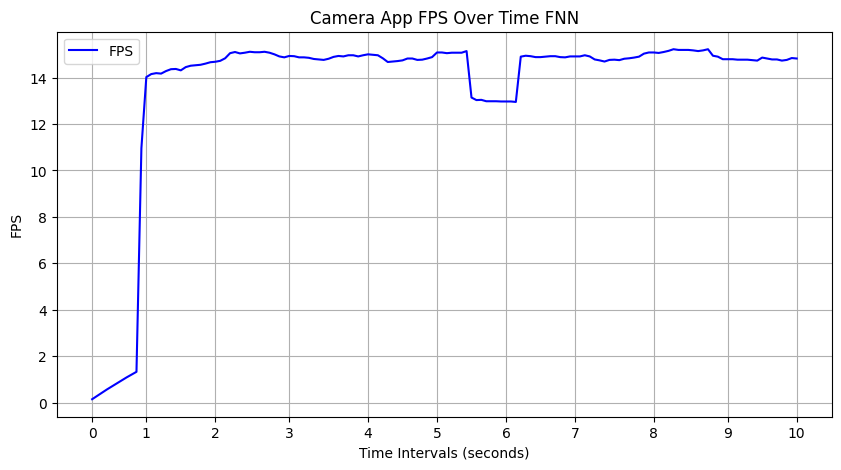

In [10]:
import matplotlib.pyplot as plt

# Example FPS data
FNN = [0.15, 0.29, 0.43, 0.57, 0.7, 0.83, 0.96, 1.09, 1.21, 1.33, 10.96, 14.02, 99, 14.15, 14.19, 14.17, 14.28, 14.36, 14.37, 14.31, 14.45, 14.51, 14.53, 14.55, 14.6, 14.66, 14.68, 99, 14.72, 14.83, 15.05, 15.1, 15.04, 15.07, 15.11, 15.09, 15.09, 15.11, 15.07, 15.0, 14.91, 14.87, 14.93, 99, 14.92, 14.87, 14.87, 14.85, 14.8, 14.78, 14.76, 14.81, 14.89, 14.93, 14.91, 14.96, 14.96, 14.91, 14.96, 15.0, 99, 14.98, 14.96, 14.83, 14.67, 14.69, 14.71, 14.74, 14.82, 14.82, 14.76, 14.77, 14.82, 14.88, 15.08, 99, 15.08, 15.05, 15.07, 15.07, 15.07, 15.14, 13.14, 13.03, 13.04, 12.98, 12.98, 12.98, 12.97, 12.97, 99, 12.97, 12.95, 14.9, 14.94, 14.92, 14.88, 14.88, 14.9, 14.92, 14.92, 14.88, 14.87, 14.91, 14.91, 99, 14.91, 14.96, 14.91, 14.78, 14.74, 14.69, 14.76, 14.77, 14.75, 14.81, 14.83, 14.86, 14.9, 15.03, 15.08, 15.08, 99, 15.06, 15.1, 15.15, 15.22, 15.19, 15.19, 15.19, 15.17, 15.14, 15.17, 15.22, 14.94, 14.9, 14.79, 14.79, 99, 14.79, 14.77, 14.77, 14.77, 14.75, 14.73, 14.86, 14.82, 14.78, 14.78, 14.73, 14.76, 14.84, 14.82, 99]


filtered_data = [value for value in FNN if value != 99]

plt.figure(figsize=(10, 5))
plt.plot(filtered_data, label="FPS", color="blue")
plt.title("Camera App FPS Over Time FNN")
plt.xlabel("Time Intervals (seconds)")
plt.ylabel("FPS")
plt.legend()

positions = [index for index, value in enumerate(FNN) if value == 99]

a = 1
fps_list = [0, ]
for i in positions:
    i = i - a
    a += 1
    fps_list.append(i)
fps_list

xname = []
for i in range(len(fps_list)):
    xname.append(str(i))

plt.xticks(fps_list, xname)
plt.grid(True)
plt.show()


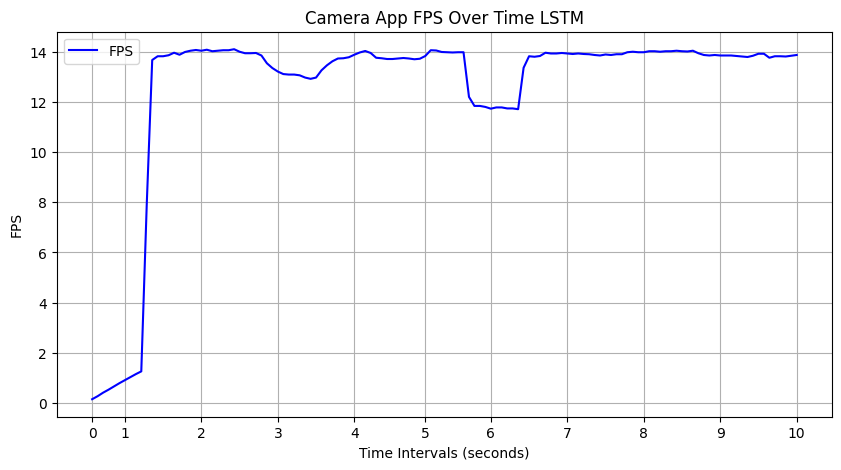

In [11]:
import matplotlib.pyplot as plt

# Example FPS data
LSTM = [0.15, 0.27, 0.41, 0.53, 0.66, 0.79, 0.91, 99, 1.03, 1.15, 1.26, 7.91, 13.67, 13.82, 13.82, 13.86, 13.96, 13.88, 13.99, 14.04, 14.07, 14.04, 99, 14.08, 14.02, 14.04, 14.06, 14.06, 14.1, 14.0, 13.94, 13.94, 13.95, 13.85, 13.54, 13.35, 13.21, 99, 13.11, 13.09, 13.09, 13.06, 12.97, 12.92, 12.97, 13.26, 13.46, 13.62, 13.73, 13.74, 13.78, 13.88, 99, 13.97, 14.03, 13.95, 13.76, 13.74, 13.71, 13.71, 13.73, 13.75, 13.73, 13.7, 13.72, 13.83, 99, 14.06, 14.05, 13.99, 13.98, 13.97, 13.98, 13.98, 12.2, 11.84, 11.84, 11.8, 11.73, 99, 11.78, 11.78, 11.74, 11.74, 11.71, 13.36, 13.82, 13.8, 13.83, 13.96, 13.93, 13.93, 13.95, 13.93, 99, 13.91, 13.93, 13.91, 13.9, 13.87, 13.85, 13.89, 13.87, 13.9, 13.9, 13.98, 14.0, 13.98, 13.98, 99, 14.02, 14.02, 14.0, 14.02, 14.02, 14.04, 14.02, 14.01, 14.04, 13.94, 13.87, 13.85, 13.87, 13.85, 99, 13.85, 13.85, 13.83, 13.81, 13.79, 13.84, 13.92, 13.92, 13.76, 13.82, 13.82, 13.81, 13.84, 13.87, 99]


filtered_data = [value for value in LSTM if value != 99]

plt.figure(figsize=(10, 5))
plt.plot(filtered_data, label="FPS", color="blue")
plt.title("Camera App FPS Over Time LSTM")
plt.xlabel("Time Intervals (seconds)")
plt.ylabel("FPS")
plt.legend()

positions = [index for index, value in enumerate(LSTM) if value == 99]

a = 1
fps_list = [0, ]
for i in positions:
    i = i - a
    a += 1
    fps_list.append(i)
fps_list

xname = []
for i in range(len(fps_list)):
    xname.append(str(i))

plt.xticks(fps_list, xname)
plt.grid(True)
plt.show()


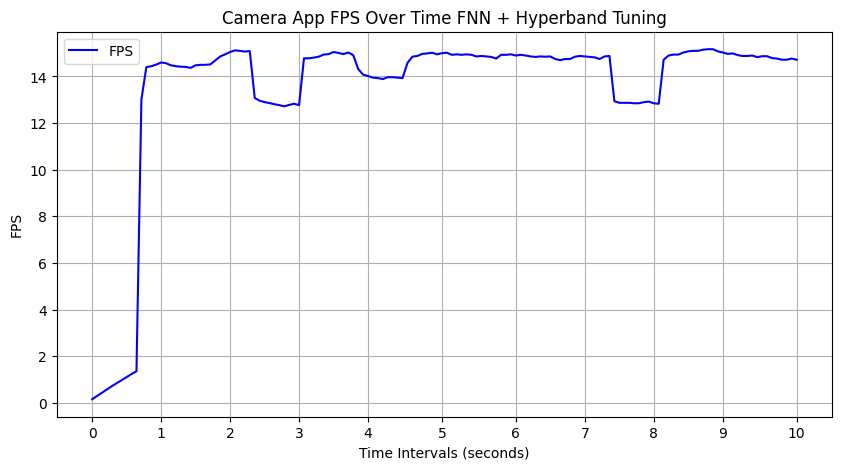

In [12]:
import matplotlib.pyplot as plt

# Example FPS data
FNNH = [0.15, 0.29, 0.43, 0.57, 0.71, 0.84, 0.97, 1.1, 1.23, 1.35, 13.01, 14.4, 14.44, 14.51, 14.6, 99, 14.57, 14.48, 14.44, 14.42, 14.41, 14.37, 14.48, 14.5, 14.5, 14.52, 14.69, 14.86, 14.95, 15.05, 99, 15.12, 15.1, 15.07, 15.09, 13.08, 12.96, 12.9, 12.86, 12.81, 12.77, 12.72, 12.78, 12.83,12.77, 99, 14.78, 14.78, 14.81, 14.85, 14.94, 14.96, 15.05, 15.01, 14.96, 15.03, 14.91, 14.32, 14.08, 14.02, 99, 13.95, 13.93, 13.89, 13.97, 13.97, 13.95, 13.93, 14.58, 14.85, 14.88, 14.97, 14.99, 15.02, 14.95, 15.0, 99, 15.02, 14.93, 14.95, 14.93, 14.95, 14.93, 14.86, 14.88, 14.86, 14.84, 14.77, 14.93, 14.93, 14.95, 14.9, 99, 14.93, 14.9, 14.86, 14.84, 14.86, 14.85, 14.86, 14.75, 14.7, 14.75, 14.75, 14.85, 14.88, 14.86, 99, 14.84, 14.82, 14.75, 14.86, 14.88, 12.94, 12.87, 12.87, 12.87, 12.85, 12.85, 12.9, 12.92, 12.85, 99, 12.83, 14.72, 14.9, 14.94, 14.94, 15.03, 15.08, 15.1, 15.1, 15.15, 15.17, 15.17, 15.08, 15.03, 99, 14.97, 14.99, 14.92, 14.88, 14.88, 14.9, 14.83, 14.87, 14.87, 14.79, 14.77, 14.72, 14.72, 14.77, 14.72, 99]


filtered_data = [value for value in FNNH if value != 99]

plt.figure(figsize=(10, 5))
plt.plot(filtered_data, label="FPS", color="blue")
plt.title("Camera App FPS Over Time FNN + Hyperband Tuning")
plt.xlabel("Time Intervals (seconds)")
plt.ylabel("FPS")
plt.legend()

positions = [index for index, value in enumerate(FNNH) if value == 99]

a = 1
fps_list = [0, ]
for i in positions:
    i = i - a
    a += 1
    fps_list.append(i)
fps_list

xname = []
for i in range(len(fps_list)):
    xname.append(str(i))

plt.xticks(fps_list, xname)
plt.grid(True)
plt.show()


[12, 24, 36, 47, 59, 71, 83, 95, 108, 120]


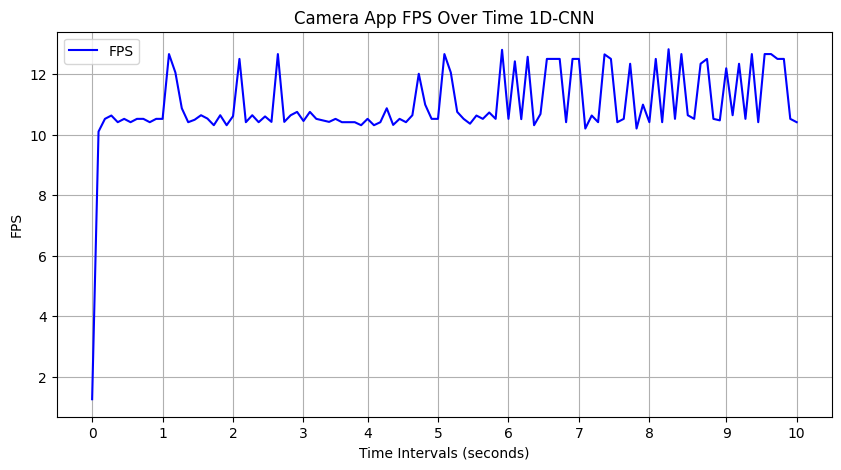

In [13]:
import matplotlib.pyplot as plt

# Example FPS data
DCNN = [1.26, 10.1, 10.52, 10.63, 10.41, 10.52, 10.41, 10.52, 10.52, 10.41, 10.52, 10.52, 99, 12.66, 12.05, 10.87, 10.41, 10.49, 10.64, 10.53, 10.31, 10.64, 10.31, 10.61, 99, 12.5, 10.41, 10.64, 10.41, 10.6, 10.42, 12.66, 10.42, 10.64, 10.75, 10.45, 99, 10.75, 10.52, 10.47, 10.42, 10.52, 10.41, 10.41, 10.41, 10.31, 10.52, 99, 10.31, 10.41, 10.87, 10.32, 10.52, 10.41, 10.64, 12.01, 10.99, 10.52, 10.52, 99, 12.66, 12.05, 10.75, 10.52, 10.36, 10.63, 10.52, 10.73, 10.52, 12.8, 10.52, 99, 12.42, 10.51, 12.57, 10.31, 10.68, 12.5, 12.5, 12.5, 10.41, 12.5, 12.5, 99, 10.2, 10.63, 10.41, 12.65, 12.5, 10.41, 10.52, 12.34, 10.2, 10.99, 10.41, 99, 12.5, 10.41, 12.82, 10.52, 12.66, 10.64, 10.52, 12.34, 12.5, 10.52, 10.47, 12.19, 99, 10.64, 12.34, 10.52, 12.66, 10.41, 12.66, 12.66, 12.5, 12.5, 10.52, 10.41,99]


filtered_data = [value for value in DCNN if value != 99]

plt.figure(figsize=(10, 5))
plt.plot(filtered_data, label="FPS", color="blue")
plt.title("Camera App FPS Over Time 1D-CNN")
plt.xlabel("Time Intervals (seconds)")
plt.ylabel("FPS")
plt.legend()

positions = [index for index, value in enumerate(DCNN) if value == 99]
print(positions)
a = 1
fps_list = [0, ]
for i in positions:
    i = i - a
    a += 1
    fps_list.append(i)
fps_list

xname = []
for i in range(len(fps_list)):
    xname.append(str(i))

plt.xticks(fps_list, xname)
plt.grid(True)
plt.show()


In [14]:
FNNpositions = [index for index, value in enumerate(FNN) if value == 99]
FNNpositions

[12, 27, 43, 60, 75, 90, 105, 122, 138, 153]

In [15]:
LSTMpositions = [index for index, value in enumerate(LSTM) if value == 99]
LSTMpositions

[7, 22, 37, 52, 66, 79, 94, 109, 124, 139]

In [16]:
FNNHpositions = [index for index, value in enumerate(FNNH) if value == 99]
FNNHpositions

[15, 30, 45, 60, 76, 92, 107, 122, 137, 153]

In [17]:
DCNNpositions = [index for index, value in enumerate(DCNN) if value == 99]
DCNNpositions


[12, 24, 36, 47, 59, 71, 83, 95, 108, 120]

In [18]:
import pandas as pd

# Define the function to split the list into intervals ending with 99
def split_intervals(lst):
    intervals = []
    current_interval = []
    for num in lst:
        current_interval.append(num)
        if num == 99:
            intervals.append(current_interval)
            current_interval = []
    return intervals

# Split FNN and LSTM lists into intervals
fnn_intervals = split_intervals(FNN)
lstm_intervals = split_intervals(LSTM)

# Find the maximum length of intervals
max_length = max(max(len(interval) for interval in fnn_intervals),
                 max(len(interval) for interval in lstm_intervals))

# Pad intervals with None to align their lengths
fnn_intervals_padded = [interval + [None] * (max_length - len(interval)) for interval in fnn_intervals]
lstm_intervals_padded = [interval + [None] * (max_length - len(interval)) for interval in lstm_intervals]

# Create a DataFrame with intervals as columns
df = pd.DataFrame({f"FNN_Interval_{i+1}": fnn_intervals_padded[i] for i in range(len(fnn_intervals))})
for i in range(len(lstm_intervals)):
    df[f"LSTM_Interval_{i+1}"] = lstm_intervals_padded[i]

# Display the resulting DataFrame
df

,FNN_Interval_1,FNN_Interval_2,FNN_Interval_3,FNN_Interval_4,FNN_Interval_5,FNN_Interval_6,FNN_Interval_7,FNN_Interval_8,FNN_Interval_9,FNN_Interval_10,LSTM_Interval_1,LSTM_Interval_2,LSTM_Interval_3,LSTM_Interval_4,LSTM_Interval_5,LSTM_Interval_6,LSTM_Interval_7,LSTM_Interval_8,LSTM_Interval_9,LSTM_Interval_10
0,0.15,14.15,14.72,14.92,14.98,15.08,12.97,14.91,15.06,14.79,0.15,1.03,14.08,13.11,13.97,14.06,11.78,13.91,14.02,13.85
1,0.29,14.19,14.83,14.87,14.96,15.05,12.95,14.96,15.10,14.77,0.27,1.15,14.02,13.09,14.03,14.05,11.78,13.93,14.02,13.85
2,0.43,14.17,15.05,14.87,14.83,15.07,14.90,14.91,15.15,14.77,0.41,1.26,14.04,13.09,13.95,13.99,11.74,13.91,14.00,13.83
3,0.57,14.28,15.10,14.85,14.67,15.07,14.94,14.78,15.22,14.77,0.53,7.91,14.06,13.06,13.76,13.98,11.74,13.90,14.02,13.81
4,0.70,14.36,15.04,14.80,14.69,15.07,14.92,14.74,15.19,14.75,0.66,13.67,14.06,12.97,13.74,13.97,11.71,13.87,14.02,13.79
5,0.83,14.37,15.07,14.78,14.71,15.14,14.88,14.69,15.19,14.73,0.79,13.82,14.10,12.92,13.71,13.98,13.36,13.85,14.04,13.84
6,0.96,14.31,15.11,14.76,14.74,13.14,14.88,14.76,15.19,14.86,0.91,13.82,14.00,12.97,13.71,13.98,13.82,13.89,14.02,13.92
7,1.09,14.45,15.09,14.81,14.82,13.03,14.90,14.77,15.17,14.82,99.00,13.86,13.94,13.26,13.73,12.20,13.80,13.87,14.01,13.92
8,1.21,14.51,15.09,14.89,14.82,13.04,14.92,14.75,15.14,14.78,NaN,13.96,13.94,13.46,13.75,11.84,13.83,13.90,14.04,13.76
9,1.33,14.53,15.11,14.93,14.76,12.98,14.92,14.81,15.17,14.78,NaN,13.88,13.95,13.62,13.73,11.84,13.96,13.90,13.94,13.82


In [19]:
import pandas as pd

# Define the function to split the list into intervals ending with 99
def split_intervals(lst):
    intervals = []
    current_interval = []
    for num in lst:
        current_interval.append(num)
        if num == 99:
            intervals.append(current_interval)
            current_interval = []
    return intervals

# Split FNN, LSTM, FNNH, and DCNN lists into intervals
fnn_intervals = split_intervals(FNN)
lstm_intervals = split_intervals(LSTM)
fnnh_intervals = split_intervals(FNNH)
dcnn_intervals = split_intervals(DCNN)

# Find the maximum length of intervals
max_length = max(max(len(interval) for interval in fnn_intervals),
                 max(len(interval) for interval in lstm_intervals),
                 max(len(interval) for interval in fnnh_intervals),
                 max(len(interval) for interval in dcnn_intervals))

# Pad intervals with None to align their lengths
fnn_intervals_padded = [interval + [None] * (max_length - len(interval)) for interval in fnn_intervals]
lstm_intervals_padded = [interval + [None] * (max_length - len(interval)) for interval in lstm_intervals]
fnnh_intervals_padded = [interval + [None] * (max_length - len(interval)) for interval in fnnh_intervals]
dcnn_intervals_padded = [interval + [None] * (max_length - len(interval)) for interval in dcnn_intervals]

# Create a DataFrame with intervals as columns
df = pd.DataFrame({f"FNN_Interval_{i+1}": fnn_intervals_padded[i] for i in range(len(fnn_intervals))})
for i in range(len(lstm_intervals)):
    df[f"LSTM_Interval_{i+1}"] = lstm_intervals_padded[i]
for i in range(len(fnnh_intervals)):
    df[f"FNNH_Interval_{i+1}"] = fnnh_intervals_padded[i]
for i in range(len(dcnn_intervals)):
    df[f"DCNN_Interval_{i+1}"] = dcnn_intervals_padded[i]

# Display the resulting DataFrame
df

,FNN_Interval_1,FNN_Interval_2,FNN_Interval_3,FNN_Interval_4,FNN_Interval_5,FNN_Interval_6,FNN_Interval_7,FNN_Interval_8,FNN_Interval_9,FNN_Interval_10,...,DCNN_Interval_1,DCNN_Interval_2,DCNN_Interval_3,DCNN_Interval_4,DCNN_Interval_5,DCNN_Interval_6,DCNN_Interval_7,DCNN_Interval_8,DCNN_Interval_9,DCNN_Interval_10
0,0.15,14.15,14.72,14.92,14.98,15.08,12.97,14.91,15.06,14.79,...,1.26,12.66,12.50,10.75,10.31,12.66,12.42,10.20,12.50,10.64
1,0.29,14.19,14.83,14.87,14.96,15.05,12.95,14.96,15.10,14.77,...,10.10,12.05,10.41,10.52,10.41,12.05,10.51,10.63,10.41,12.34
2,0.43,14.17,15.05,14.87,14.83,15.07,14.90,14.91,15.15,14.77,...,10.52,10.87,10.64,10.47,10.87,10.75,12.57,10.41,12.82,10.52
3,0.57,14.28,15.10,14.85,14.67,15.07,14.94,14.78,15.22,14.77,...,10.63,10.41,10.41,10.42,10.32,10.52,10.31,12.65,10.52,12.66
4,0.70,14.36,15.04,14.80,14.69,15.07,14.92,14.74,15.19,14.75,...,10.41,10.49,10.60,10.52,10.52,10.36,10.68,12.50,12.66,10.41
5,0.83,14.37,15.07,14.78,14.71,15.14,14.88,14.69,15.19,14.73,...,10.52,10.64,10.42,10.41,10.41,10.63,12.50,10.41,10.64,12.66
6,0.96,14.31,15.11,14.76,14.74,13.14,14.88,14.76,15.19,14.86,...,10.41,10.53,12.66,10.41,10.64,10.52,12.50,10.52,10.52,12.66
7,1.09,14.45,15.09,14.81,14.82,13.03,14.90,14.77,15.17,14.82,...,10.52,10.31,10.42,10.41,12.01,10.73,12.50,12.34,12.34,12.50
8,1.21,14.51,15.09,14.89,14.82,13.04,14.92,14.75,15.14,14.78,...,10.52,10.64,10.64,10.31,10.99,10.52,10.41,10.20,12.50,12.50
9,1.33,14.53,15.11,14.93,14.76,12.98,14.92,14.81,15.17,14.78,...,10.41,10.31,10.75,10.52,10.52,12.80,12.50,10.99,10.52,10.52


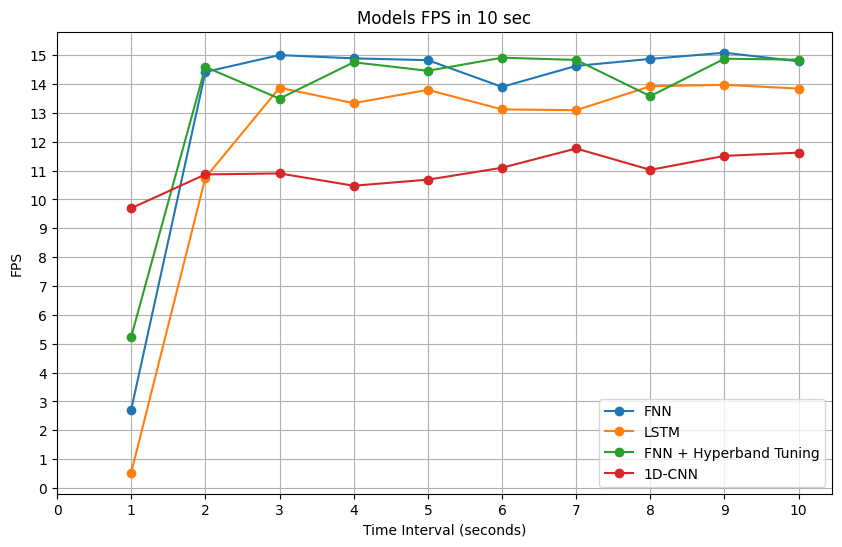

,FNN_Interval_1,FNN_Interval_2,FNN_Interval_3,FNN_Interval_4,FNN_Interval_5,FNN_Interval_6,FNN_Interval_7,FNN_Interval_8,FNN_Interval_9,FNN_Interval_10,...,DCNN_Interval_1,DCNN_Interval_2,DCNN_Interval_3,DCNN_Interval_4,DCNN_Interval_5,DCNN_Interval_6,DCNN_Interval_7,DCNN_Interval_8,DCNN_Interval_9,DCNN_Interval_10
0,0.15,14.15,14.72,14.92,14.98,15.08,12.97,14.91,15.06,14.79,...,1.26,12.66,12.50,10.75,10.31,12.66,12.42,10.20,12.50,10.64
1,0.29,14.19,14.83,14.87,14.96,15.05,12.95,14.96,15.10,14.77,...,10.10,12.05,10.41,10.52,10.41,12.05,10.51,10.63,10.41,12.34
2,0.43,14.17,15.05,14.87,14.83,15.07,14.90,14.91,15.15,14.77,...,10.52,10.87,10.64,10.47,10.87,10.75,12.57,10.41,12.82,10.52
3,0.57,14.28,15.10,14.85,14.67,15.07,14.94,14.78,15.22,14.77,...,10.63,10.41,10.41,10.42,10.32,10.52,10.31,12.65,10.52,12.66
4,0.70,14.36,15.04,14.80,14.69,15.07,14.92,14.74,15.19,14.75,...,10.41,10.49,10.60,10.52,10.52,10.36,10.68,12.50,12.66,10.41
5,0.83,14.37,15.07,14.78,14.71,15.14,14.88,14.69,15.19,14.73,...,10.52,10.64,10.42,10.41,10.41,10.63,12.50,10.41,10.64,12.66
6,0.96,14.31,15.11,14.76,14.74,13.14,14.88,14.76,15.19,14.86,...,10.41,10.53,12.66,10.41,10.64,10.52,12.50,10.52,10.52,12.66
7,1.09,14.45,15.09,14.81,14.82,13.03,14.90,14.77,15.17,14.82,...,10.52,10.31,10.42,10.41,12.01,10.73,12.50,12.34,12.34,12.50
8,1.21,14.51,15.09,14.89,14.82,13.04,14.92,14.75,15.14,14.78,...,10.52,10.64,10.64,10.31,10.99,10.52,10.41,10.20,12.50,12.50
9,1.33,14.53,15.11,14.93,14.76,12.98,14.92,14.81,15.17,14.78,...,10.41,10.31,10.75,10.52,10.52,12.80,12.50,10.99,10.52,10.52


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the function to split the list into intervals ending with 99
def split_intervals(lst):
    intervals = []
    current_interval = []
    for num in lst:
        current_interval.append(num)
        if num == 99:
            intervals.append(current_interval)
            current_interval = []
    return intervals

# Split FNN, LSTM, FNNH, and DCNN lists into intervals
fnn_intervals = split_intervals(FNN)
lstm_intervals = split_intervals(LSTM)
fnnh_intervals = split_intervals(FNNH)
dcnn_intervals = split_intervals(DCNN)

# Replace 99 with NaN
fnn_intervals = [[np.nan if num == 99 else num for num in interval] for interval in fnn_intervals]
lstm_intervals = [[np.nan if num == 99 else num for num in interval] for interval in lstm_intervals]
fnnh_intervals = [[np.nan if num == 99 else num for num in interval] for interval in fnnh_intervals]
dcnn_intervals = [[np.nan if num == 99 else num for num in interval] for interval in dcnn_intervals]

# Find the maximum length of intervals
max_length = max(max(len(interval) for interval in fnn_intervals),
                 max(len(interval) for interval in lstm_intervals),
                 max(len(interval) for interval in fnnh_intervals),
                 max(len(interval) for interval in dcnn_intervals))

# Pad intervals with None to align their lengths
fnn_intervals_padded = [interval + [None] * (max_length - len(interval)) for interval in fnn_intervals]
lstm_intervals_padded = [interval + [None] * (max_length - len(interval)) for interval in lstm_intervals]
fnnh_intervals_padded = [interval + [None] * (max_length - len(interval)) for interval in fnnh_intervals]
dcnn_intervals_padded = [interval + [None] * (max_length - len(interval)) for interval in dcnn_intervals]

# Create a DataFrame with intervals as columns
df = pd.DataFrame({f"FNN_Interval_{i+1}": fnn_intervals_padded[i] for i in range(len(fnn_intervals))})
for i in range(len(lstm_intervals)):
    df[f"LSTM_Interval_{i+1}"] = lstm_intervals_padded[i]
for i in range(len(fnnh_intervals)):
    df[f"FNNH_Interval_{i+1}"] = fnnh_intervals_padded[i]
for i in range(len(dcnn_intervals)):
    df[f"DCNN_Interval_{i+1}"] = dcnn_intervals_padded[i]

# Plot the data
x = range(1, 11)  # 10 intervals
plt.figure(figsize=(10, 6))

# Plot each list as a line
y_fnn = [np.nanmean(interval) for interval in fnn_intervals]
y_lstm = [np.nanmean(interval) for interval in lstm_intervals]
y_fnnh = [np.nanmean(interval) for interval in fnnh_intervals]
y_dcnn = [np.nanmean(interval) for interval in dcnn_intervals]

plt.plot(x, y_fnn, label="FNN", marker="o")
plt.plot(x, y_lstm, label="LSTM", marker="o")
plt.plot(x, y_fnnh, label="FNN + Hyperband Tuning", marker="o")
plt.plot(x, y_dcnn, label="1D-CNN", marker="o")

plt.xlabel("Time Interval (seconds)")
plt.ylabel("FPS")
plt.title("Models FPS in 10 sec")
plt.legend()
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.grid(True)
plt.show()

# Display the resulting DataFrame
df
